In [1]:
%load_ext autoreload
%autoreload 2

import time
import itertools

import numpy as np
import pickle as pkl

from scipy import spatial as spatial
from scipy import sparse as sp
from sklearn.preprocessing import scale

from steenroder import *
import gudhi

from matplotlib import pyplot as plt

In [2]:
def get_density_filtered_point_cloud(weight_array,
                                     k_th_nearest=200,
                                     percentage=0.3,
                                     user_axis=1):
    """
    Returns a density filtered point cloud of 9-vectors
    Parameters
    ----------
    weight_array: array
        An array of 9-dimensional points i.e the weights of 3x3 patches
    k_th_nearest : integer, optional, default: 200
        Indicates the k-th neighbour used as a density estimator
    percentage : integer, optional, default: 0.3
        The percentage of the point cloud cardinality to be left after filtration
    user_axis :
        integer 0 or 1 for scaling axis, 0 is column normalization, 1 is row norm.
    """
    normalized_weight_array = scale(weight_array, axis=user_axis)
    m_dimension, n_dimension = normalized_weight_array.shape
    number_of_kth_densest_points = int(percentage*m_dimension)
    condensed_weight_distance_matrix = spatial.distance.pdist(normalized_weight_array)
    redundant_weight_distance_matrix = spatial.distance.squareform(condensed_weight_distance_matrix)
    kth_nearest_index_matrix = np.argsort(redundant_weight_distance_matrix, axis=1)
    kth_nearest_index_vector = np.zeros((m_dimension, 1), dtype=int)
    for i in range(m_dimension):
        kth_nearest_index = kth_nearest_index_matrix[i][k_th_nearest]
        kth_nearest_index_vector[i] = kth_nearest_index
    # kth_nearest_distances = redundant_weight_distance_matrix[kth_nearest_index_vector]
    kth_nearest_distances = np.take_along_axis(redundant_weight_distance_matrix,
                                               kth_nearest_index_vector, axis=1)
    kth_nearest_indices_sorted = np.argsort(kth_nearest_distances, axis=0)
    p_of_kth_nearest_indices = kth_nearest_indices_sorted[0:number_of_kth_densest_points]
    pth_densest_points = normalized_weight_array[p_of_kth_nearest_indices]
    pth_densest_points = np.reshape(pth_densest_points, (-1, n_dimension))

    return pth_densest_points

In [3]:
def remove_trivial_bars(filtration, barcode):
    """Note: filtration is as returned by GUDHI, i.e. [(simplex_tuple, filtration value), ...]"""
    N = len(filtration)
    barcode_vals = []
    for barcode_in_dim in barcode:
        barcode_vals_in_dim = []
        for tup in barcode_in_dim:
            if not np.isinf(tup[1]):
                candidate = (filtration[N - 1 - tup[0]][1], filtration[N - 1 - tup[1]][1])
                if candidate[0] != candidate[1]:
                    barcode_vals_in_dim.append(candidate)
            else:
                barcode_vals_in_dim.append((filtration[N - 1 - tup[0]][1], -np.inf))
        barcode_vals.append(barcode_vals_in_dim)
    
    return barcode_vals

In [4]:
weights = np.load('weights_100n_86e.npy').reshape(-1, 9)

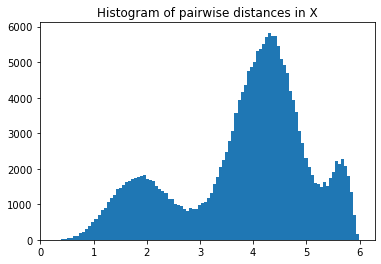

In [5]:
X = get_density_filtered_point_cloud(weights, k_th_nearest=200, percentage=0.02, user_axis=1)

dm = spatial.distance.pdist(X)
plt.hist(dm, bins=100);
plt.title("Histogram of pairwise distances in X");
plt.show()

In [6]:
k = 1

# Without edge collapse

In [107]:
rips_complex = gudhi.RipsComplex(points=X)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

filtration = []
for s in simplex_tree.get_filtration():
    filtration.append(s)
    
print(f"Filtration with {len(filtration)} simplices")

Filtration with 349632 simplices


In [108]:
barcode, st_barcode = barcodes(k, [tuple(s[0]) for s in filtration])

In [109]:
st_barcode

[[], [], []]

In [132]:
barcode_by_values = remove_trivial_bars(filtration, barcode)

# With edge collapse

In [7]:
rips_complex_coll = gudhi.RipsComplex(points=X)
simplex_tree_coll = rips_complex_coll.create_simplex_tree(max_dimension=1)  # Only get the 1-skeleton this time

In [59]:
simplex_tree_coll.collapse_edges(nb_iterations=10000)  # Run this cell several times if you want to iteratively collapse

In [60]:
filtration_coll = []
for s in simplex_tree_coll.get_filtration():
    filtration_coll.append(s)

print(f"Filtration with {len(filtration_coll)} simplices")

Filtration with 6764 simplices


In [65]:
simplex_tree_coll.expansion(3)  # Get the three-simplices after collapse

In [66]:
filtration_coll = []
for s in simplex_tree_coll.get_filtration():
    filtration_coll.append(s)

print(f"Filtration with {len(filtration_coll)} simplices")

Filtration with 108662 simplices


In [67]:
barcode_coll, st_barcode_coll = barcodes(k, [tuple(s[0]) for s in filtration_coll])

In [69]:
st_barcode_coll

[[], [], [], []]